# Applying Machine Learning Models

In [23]:
import numpy as np
import pandas as pd
import itertools
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from datetime import datetime

from sklearn import linear_model
# metrics: 計測 → 評価
from sklearn import metrics

from sklearn.model_selection import GridSearchCV
# カーネルなしSVM（SVC: Support Vector Classifierの略）
from sklearn.svm import LinearSVC
# カーネル法を用いたSVM
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier


In [24]:
data1 = pd.read_csv('Data_UCI_not_noise_1.csv')
data2 = pd.read_csv('Data_UCI_not_noise_2.csv')

df_concat = pd.concat([data1, data2])

df_concat = df_concat[df_concat["user_Id"] != 25]

print(df_concat.shape)

(8859, 642)


In [25]:
features_act = list()
features_uid = list()

with open('act_feature_importance.txt', 'r') as f:
    features_act = f.read().splitlines()

with open('uid_feature_importance.txt', 'r') as f:
    features_uid = f.read().splitlines()

print(len(features_act))
# print(features_uid)

640


In [26]:
from sklearn.model_selection import train_test_split

def split_train_test_data(df, id):
  X = df.drop(['user_Id', 'activity_Id'], axis=1)
  y = df[id]

  return train_test_split(X, y, test_size=0.33, random_state=42) # X_train, X_test, y_train, y_test

  # for i in X_train.columns:
  #   print(X_train[i].dtype)
  # print(X_train.dtypes)

  # # 訓練用
  # X_train = train.drop(['subject', 'Activity', 'ActivityName'], axis=1)
  # y_train = train['subject']

  # # テスト用
  # X_test = test.drop(['subject', 'Activity', 'ActivityName'], axis=1)
  # y_test = test['subject']

  # print('X_train and y_train : ({},{})'.format(X_train.shape, y_train.shape))
  # print('X_test  and y_test  : ({},{})'.format(X_test.shape, y_test.shape))

Let's make a function to plot the confusion matrix

In [27]:
plt.rcParams['font.family'] = 'DejaVu Sans'

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):
    
    # normalize → 正規化
    if normalize:
        # cmの値は予測結果と実際の値の一致数なので，それを列の合計で割ると確率
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] # np.newaxisは次元を追加
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        # plt.text(): 座標（x, y），表示するテキスト，文字位置，色指定
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment='center', color='white' if cm[i, j] > thresh else 'black')
    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Let's make a function to run any model specified

In [28]:
# 任意のモデルを実行
def perform_model_epsilon(model, X_train, y_train, X_test, y_test, class_labels, cm_nomalize=True, print_cm=True, cm_cmap=plt.cm.Greens):
    
    # to store results at various phases
    results = dict()
    
    # time at which model starts training 
    train_start_time = datetime.now()
    print('training the model...')
    model.fit(X_train, y_train)
    print('Done')
    train_end_time = datetime.now()
    results['training_time'] = train_end_time - train_start_time
    print('==> training time:- {}\n'.format(results['training_time']))
    
    # predict test data
    print('Predicting test data')
    test_start_time = datetime.now()
    y_pred = model.predict(X_test)
    test_end_time = datetime.now()
    results['testing_time'] = test_end_time - test_start_time
    print('==> testing time:- {}\n'.format(results['testing_time']))
    # 予測結果を格納
    results['predicted'] = y_pred
    
    # calculate overall accuracy of the model
    accuracy = metrics.accuracy_score(y_true=y_test, y_pred=y_pred)
    # store accuracy in results
    results['accuracy'] = accuracy
    print('==> Accuracy:- {}\n'.format(accuracy))
    
    # confusion matrix
    cm = metrics.confusion_matrix(y_test, y_pred)
    results['confusion_matrix'] = cm
    # output confusion matrix
    if print_cm:
        print('\n ********Confusion Matrix********')
        print('\n {}'.format(cm))
    
    # plot confusion matrix
    plt.figure(figsize=(15, 15))
    plt.grid(b=False) # グリッドを非表示
    plot_confusion_matrix(cm, classes=class_labels, normalize=True, title='Normalized Confusion Matrix', cmap = cm_cmap)
    plt.show()
    
    # get classification report
    # print('****************| Classifiction Report |****************')
    # classification_report = metrics.classification_report(y_test, y_pred)
    
    # # store report in results
    # results['classification_report'] = classification_report
    # print(classification_report)
    
    # get f1 score
    f1 = metrics.f1_score(y_test, y_pred, average="macro")
    print("\n F1 Score:{}".format(f1))
    
    # add the trained model to the results
    results['model'] = model
    
    return results, f1
    

Make function to print the gridsearch Parameters

In [29]:
# 同一モデルでの値を表示
def print_grid_search_attributes(model):
    
    # Estimator that gave highest score among all the estimators formed in GridSearch
    print('\n\n==> Best Estimator:')
    print('\t{}\n'.format(model.best_estimator_))
    
    # parameters that gave best results while perfoming grid search
    print('\n==> Best parameters:')
    print('\tParameters of best estimator : {}'.format(model.best_params_))
    
    # number of cross validation splits
    print('\n==> No. of CrossValidation sets:')
    print('\tTotal nmber of cross validation sets: {}'.format(model.n_splits_))
    
    # Average cross validated score of the best estimator, from the Grid Search
    print('\n==> Best Score:')
    print('\tAverage Cross Validate scores of Best estimator : {}'.format(model.best_score_))

In [30]:
labels_act = ['WALKING', 'WALKING_UPSTAIRS', 'WALKING_DOWNSTAIRS', 'SITTING', 'STANDING', 'LAYING']

labels_uid = list()
for i in range(1, 31):
    if i != 25:
        labels_uid.append(i)

In [31]:
n = 119
# f_add_weighted_noise = set()
# for f in features_uid[:n]:
#   f_add_weighted_noise.add(f)
# print(f_add_weighted_noise)

# n = 211
f_add_weighted_noise = set()
for f in features_uid[:n]:
  # 重複していないものを入れる
  if f not in features_act[:n]:
    f_add_weighted_noise.add(f)
print(len(f_add_weighted_noise))

83


In [32]:
weighted_epsilon_array = [0.001, 0.005, 0.008, 0.01, 0.015, 0.02, 0.03, 0.04, 0.05, 0.08, 0.1]
weighted_epsilon = weighted_epsilon_array[0]

## 2. Random Forest Classifier

## UID

--------
epsilon:  1.1
--------
training the model...
Fitting 10 folds for each of 20 candidates, totalling 200 fits
Done
==> training time:- 0:14:50.253500

Predicting test data
==> testing time:- 0:00:00.216949

==> Accuracy:- 0.051641586867305064


 ********Confusion Matrix********

 [[13  1  0  0  0  0  0  0  0  1  0  0  6  0  0  6  7 15  0  0 16  1  1 12
  12 14  0  7  5]
 [ 8  1  0  0  0  0  0  0  0  1  0  0  1  0  0 10  4 12  0  0 23  0  0 17
   8 10  3  5  3]
 [ 3  0  0  0  0  0  0  0  0  0  3  0  3  0  0  9  7 10  1  1 10  1  1 20
   9 12  2  4  2]
 [ 4  0  0  1  1  0  0  0  0  0  0  0  1  0  0  7  6  8  0  0 15  0  1 16
   6  8  0 11  6]
 [ 3  1  0  0  0  0  1  0  0  0  2  0  2  0  1  3  6 10  0  1 13  0  0 14
   8  1  0 16  4]
 [ 7  0  1  0  0  0  2  0  0  0  0  0  2  0  3  8  4  9  0  0 10  0  3 14
   9  6  1  8  6]
 [ 4  1  0  0  0  0  0  0  0  1  1  0  1  0  0  9  9 13  0  0 13  0  3  7
   7  6  0  8  1]
 [ 5  0  0  0  0  0  0  0  0  0  0  0  3  1  0  6  7  6  1  1  5  0 

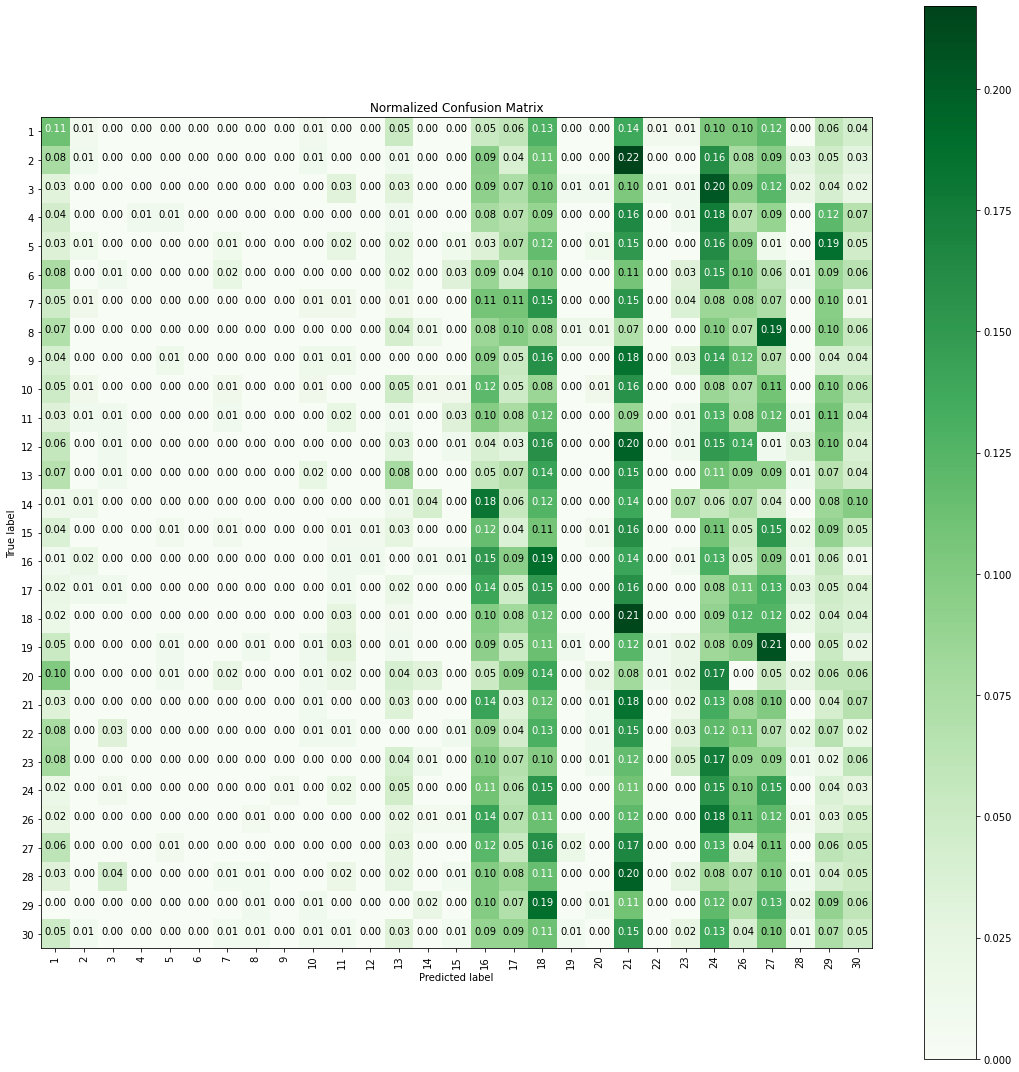


 F1 Score:0.03628955813844361


==> Best Estimator:
	RandomForestClassifier(max_depth=12, n_estimators=180)


==> Best parameters:
	Parameters of best estimator : {'max_depth': 12, 'n_estimators': 180}

==> No. of CrossValidation sets:
	Total nmber of cross validation sets: 10

==> Best Score:
	Average Cross Validate scores of Best estimator : 0.06200282760147853
--------
epsilon:  1.2
--------
training the model...
Fitting 10 folds for each of 20 candidates, totalling 200 fits
Done
==> training time:- 0:12:23.591130

Predicting test data
==> testing time:- 0:00:00.123750

==> Accuracy:- 0.05950752393980848


 ********Confusion Matrix********

 [[14  0  1  0  0  0  0  0  0  2  0  0  3  0  1  5  7 15  0  0 26  0  2  5
  10 10  0  7  9]
 [ 6  0  0  0  0  1  1  0  0  0  0  0  6  0  0 18  0 20  0  0 21  0  0 13
   7  3  1  5  4]
 [ 7  0  1  0  0  0  0  0  0  0  0  0  1  0  0 10  7 14  0  1 16  0  2 11
   7  9  1 10  1]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  8  7  7  0  1 17  0  1

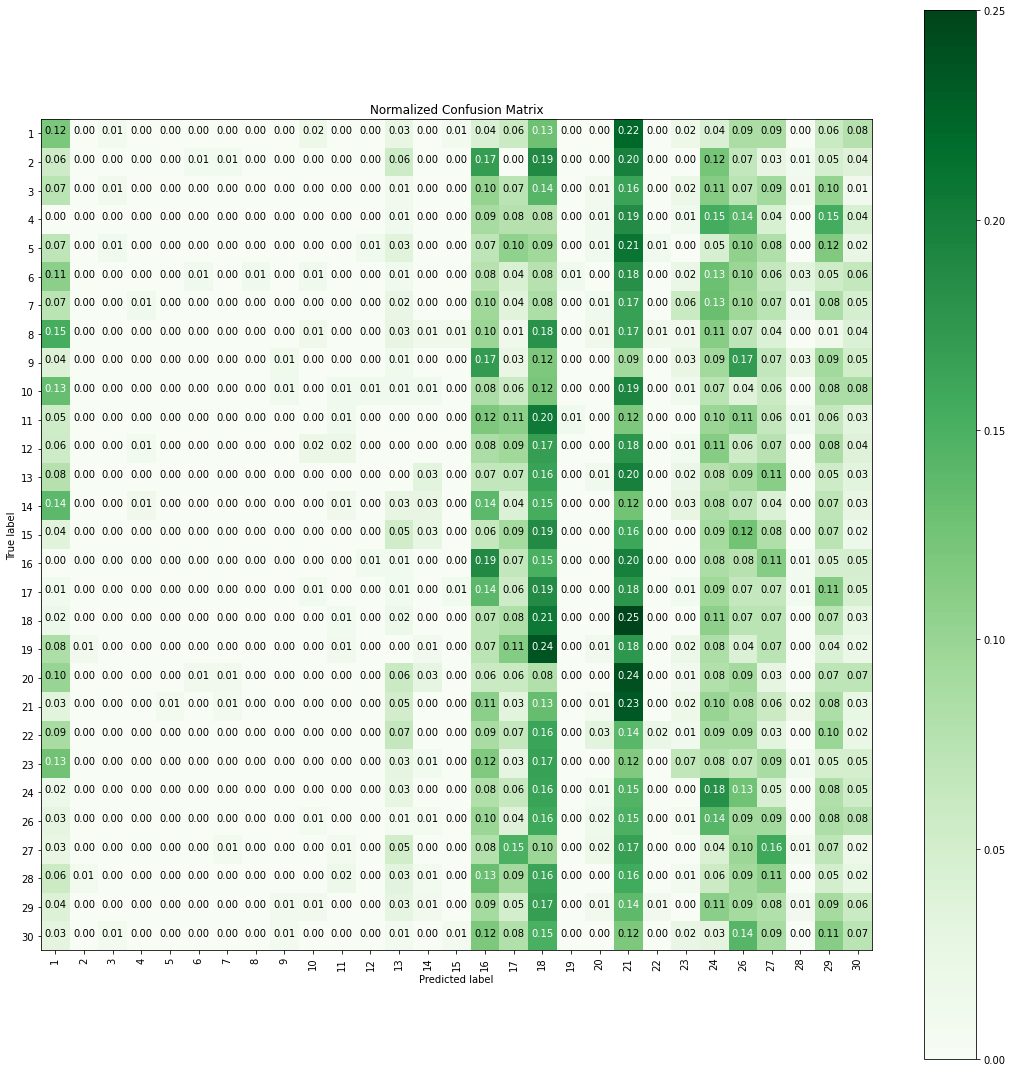


 F1 Score:0.03717706310683446


==> Best Estimator:
	RandomForestClassifier(max_depth=10, n_estimators=170)


==> Best parameters:
	Parameters of best estimator : {'max_depth': 10, 'n_estimators': 170}

==> No. of CrossValidation sets:
	Total nmber of cross validation sets: 10

==> Best Score:
	Average Cross Validate scores of Best estimator : 0.06537266992578965
--------
epsilon:  1.3
--------
training the model...
Fitting 10 folds for each of 20 candidates, totalling 200 fits
Done
==> training time:- 0:12:05.627086

Predicting test data
==> testing time:- 0:00:00.114149

==> Accuracy:- 0.057797537619699045


 ********Confusion Matrix********

 [[12  1  1  0  3  0  2  0  0  2  0  0  2  2  0  9 11 11  1  0 16  0  5  6
   8 13  0  8  4]
 [ 3  0  0  0  0  0  0  0  0  1  0  2  4  2  1 10  5 15  1  0 23  0  1 13
   5 11  1  5  3]
 [ 4  0  1  1  0  0  1  0  0  1  0  0  2  1  0 11  5  6  0  0 22  0  1 14
   6  6  0 13  3]
 [ 2  0  1  0  0  0  1  0  0  0  0  0  3  0  1  1  4  9  0  0 18  0  

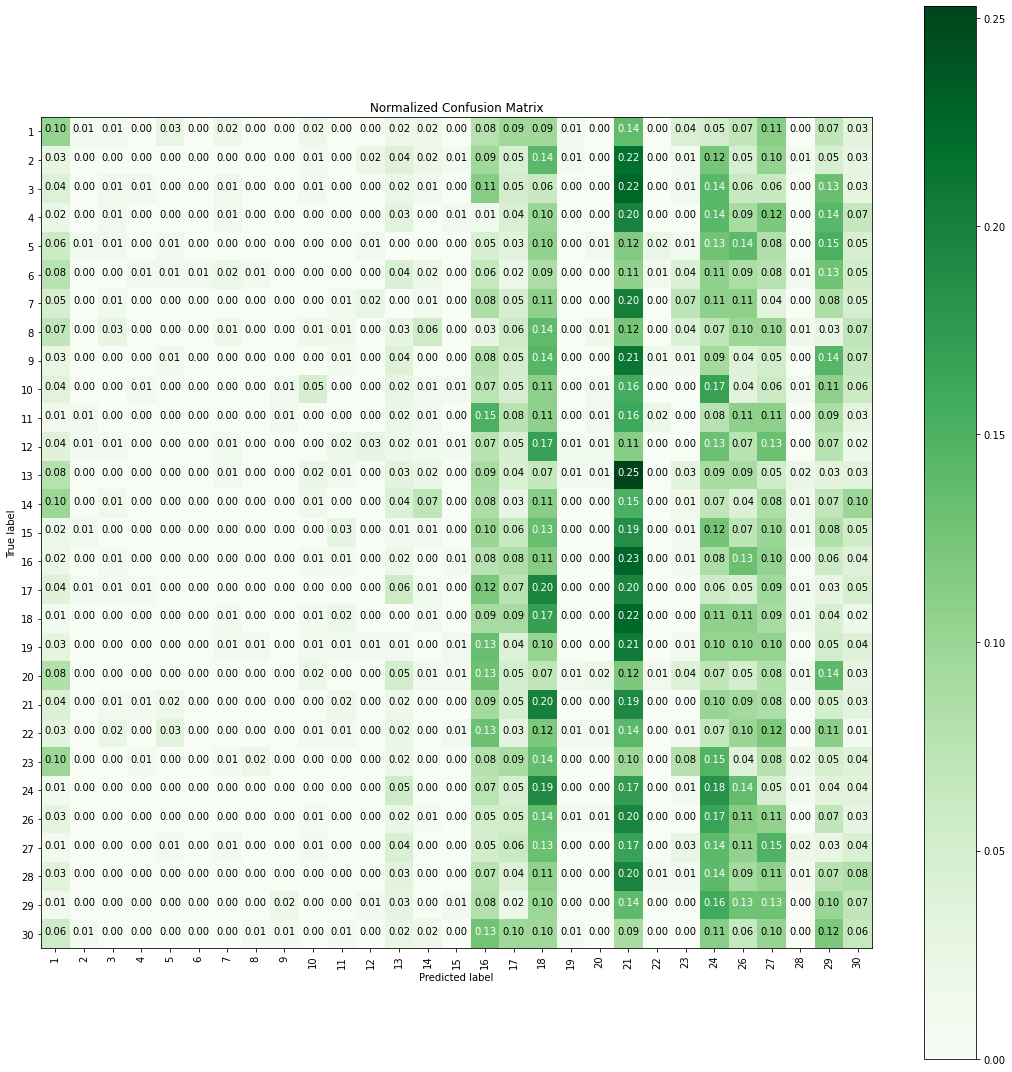


 F1 Score:0.04205620586207088


==> Best Estimator:
	RandomForestClassifier(max_depth=12, n_estimators=170)


==> Best parameters:
	Parameters of best estimator : {'max_depth': 12, 'n_estimators': 170}

==> No. of CrossValidation sets:
	Total nmber of cross validation sets: 10

==> Best Score:
	Average Cross Validate scores of Best estimator : 0.06520034521720862
--------
epsilon:  1.4
--------
training the model...
Fitting 10 folds for each of 20 candidates, totalling 200 fits
Done
==> training time:- 0:14:42.055866

Predicting test data
==> testing time:- 0:00:00.203101

==> Accuracy:- 0.06224350205198358


 ********Confusion Matrix********

 [[ 9  0  3  0  1  1  1  0  0  1  1  0  2  2  0  7  9 17  0  3 14  1  3  5
   8 10  1 12  6]
 [ 7  4  0  1  0  0  4  1  0  1  0  0  3  0  0  7  8  6  0  1 21  0  2  7
  10 10  2  7  4]
 [ 3  0  0  0  1  0  2  0  1  0  0  0  4  1  0  5  6 13  0  0 14  0  0 14
   5 10  1  9  9]
 [ 3  0  1  0  1  0  0  0  0  1  2  0  2  0  0  5  9  8  1  0 13  1  0

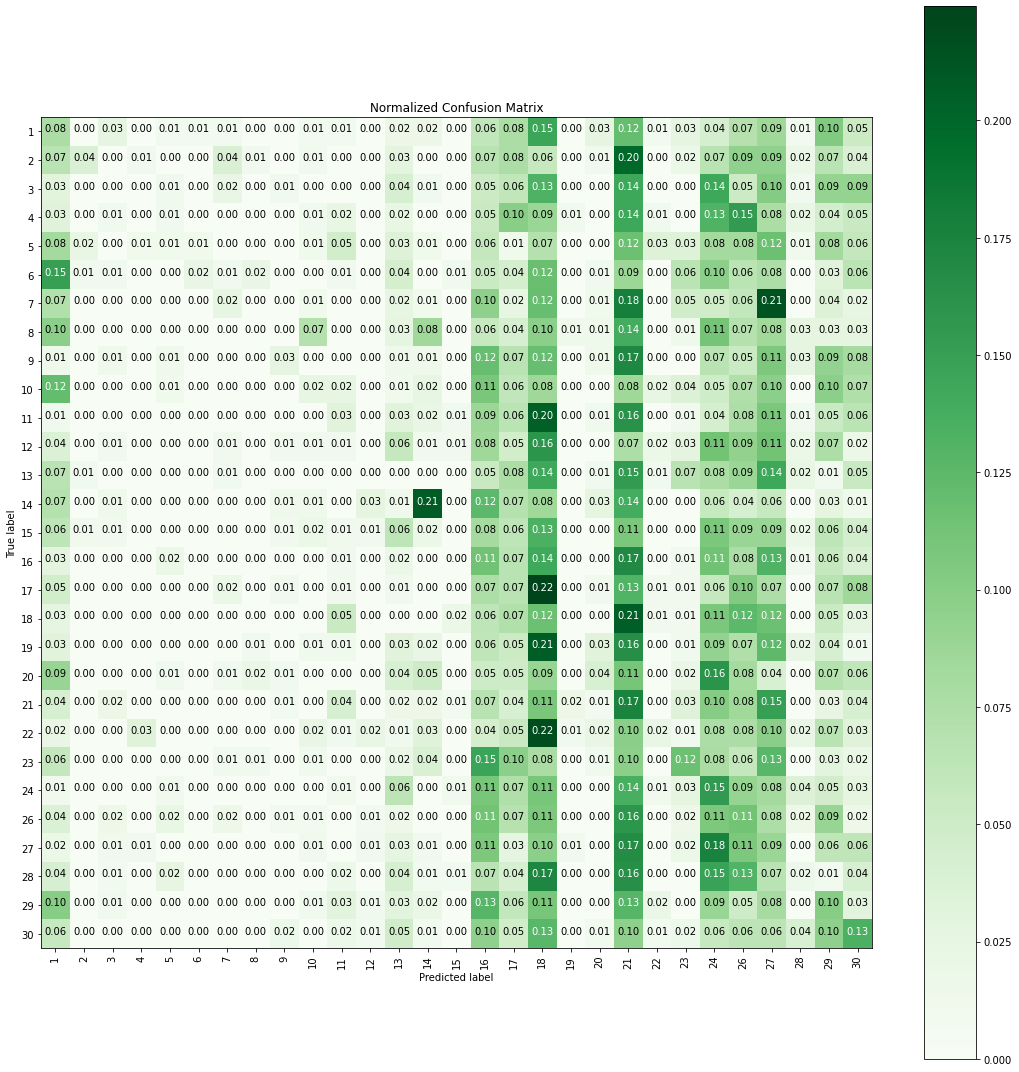


 F1 Score:0.053107270172129815


==> Best Estimator:
	RandomForestClassifier(max_depth=12, n_estimators=160)


==> Best parameters:
	Parameters of best estimator : {'max_depth': 12, 'n_estimators': 160}

==> No. of CrossValidation sets:
	Total nmber of cross validation sets: 10

==> Best Score:
	Average Cross Validate scores of Best estimator : 0.07093560677034538
--------
epsilon:  1.8
--------
training the model...
Fitting 10 folds for each of 20 candidates, totalling 200 fits
Done
==> training time:- 0:19:03.631418

Predicting test data
==> testing time:- 0:00:00.333192

==> Accuracy:- 0.10191518467852258


 ********Confusion Matrix********

 [[34  0  0  0  1  0  1  0  0  0  1  0  3  1  0  8  3 11  0  1 16  0  4  6
   7  8  0  4  8]
 [10  0  0  0  0  0  0  0  0  1  0  0  1  2  0 10  3 11  0  0 27  0  0 11
   8 11  0  8  3]
 [ 6  0  0  0  0  0  0  1  0  0  0  0  2  0  0  6  7 17  0  0 21  0  0 13
   9 10  0  3  3]
 [ 5  0  0  0  0  0  0  0  0  1  1  0  0  0  0  2  5 13  0  0 15  1  

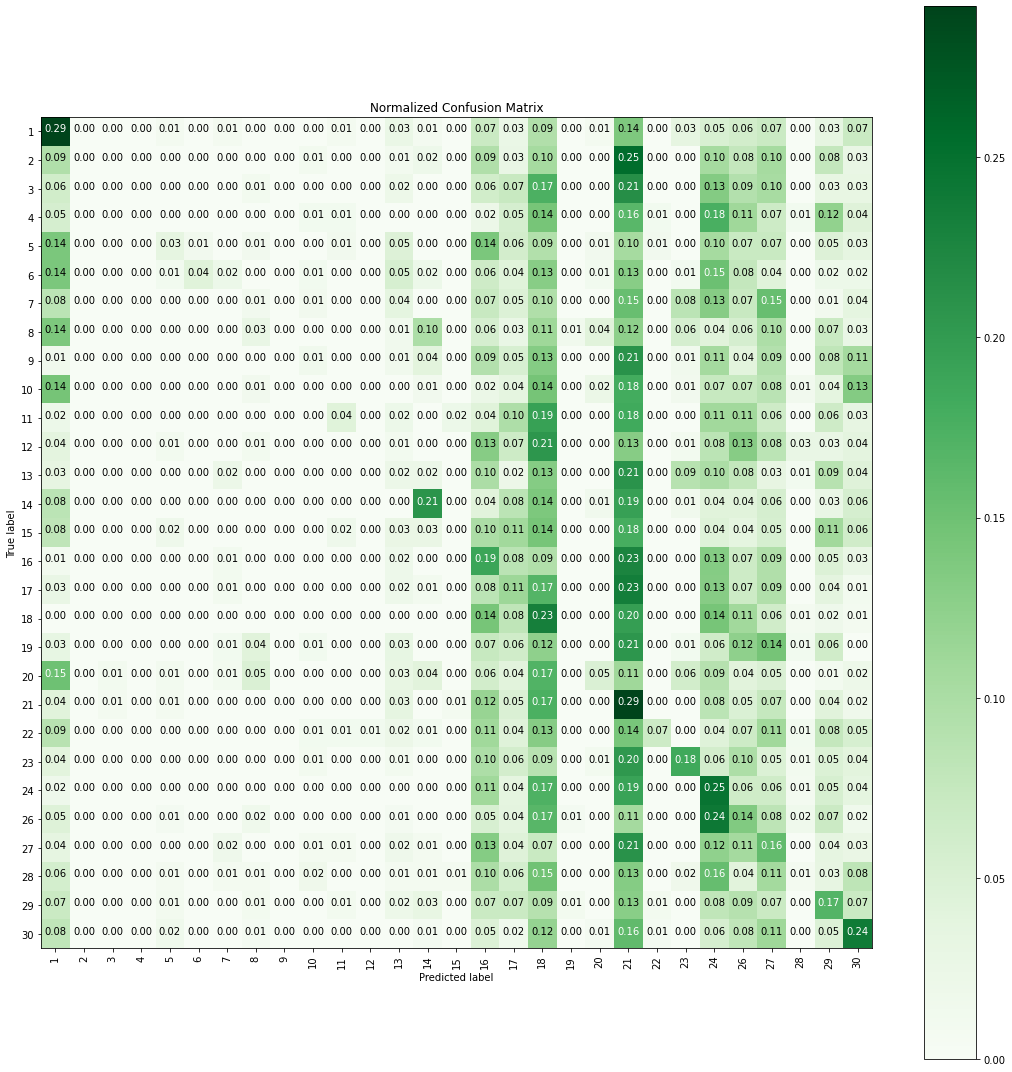


 F1 Score:0.07911290597280803


==> Best Estimator:
	RandomForestClassifier(max_depth=8, n_estimators=180)


==> Best parameters:
	Parameters of best estimator : {'max_depth': 8, 'n_estimators': 180}

==> No. of CrossValidation sets:
	Total nmber of cross validation sets: 10

==> Best Score:
	Average Cross Validate scores of Best estimator : 0.102273720907785
--------
epsilon:  1.9
--------
training the model...
Fitting 10 folds for each of 20 candidates, totalling 200 fits
Done
==> training time:- 0:16:18.541571

Predicting test data
==> testing time:- 0:00:00.232852

==> Accuracy:- 0.10020519835841313


 ********Confusion Matrix********

 [[36  1  0  0  0  1  0  1  1  0  2  0  5  2  0  7  1 10  0  1 11  0  4  5
   4 12  1  6  6]
 [ 8  1  2  2  1  0  0  0  0  4  1  0  5  1  0 10  7  8  0  0 20  1  0  9
   7  9  0  6  4]
 [ 4  0  1  1  1  0  0  0  1  2  2  1  2  1  0 13 12 10  0  0 16  1  1  8
   3  8  1  4  5]
 [ 3  1  2  2  4  0  0  0  0  2  1  0  0  0  2  5  3 19  1  0  9  1  1  7


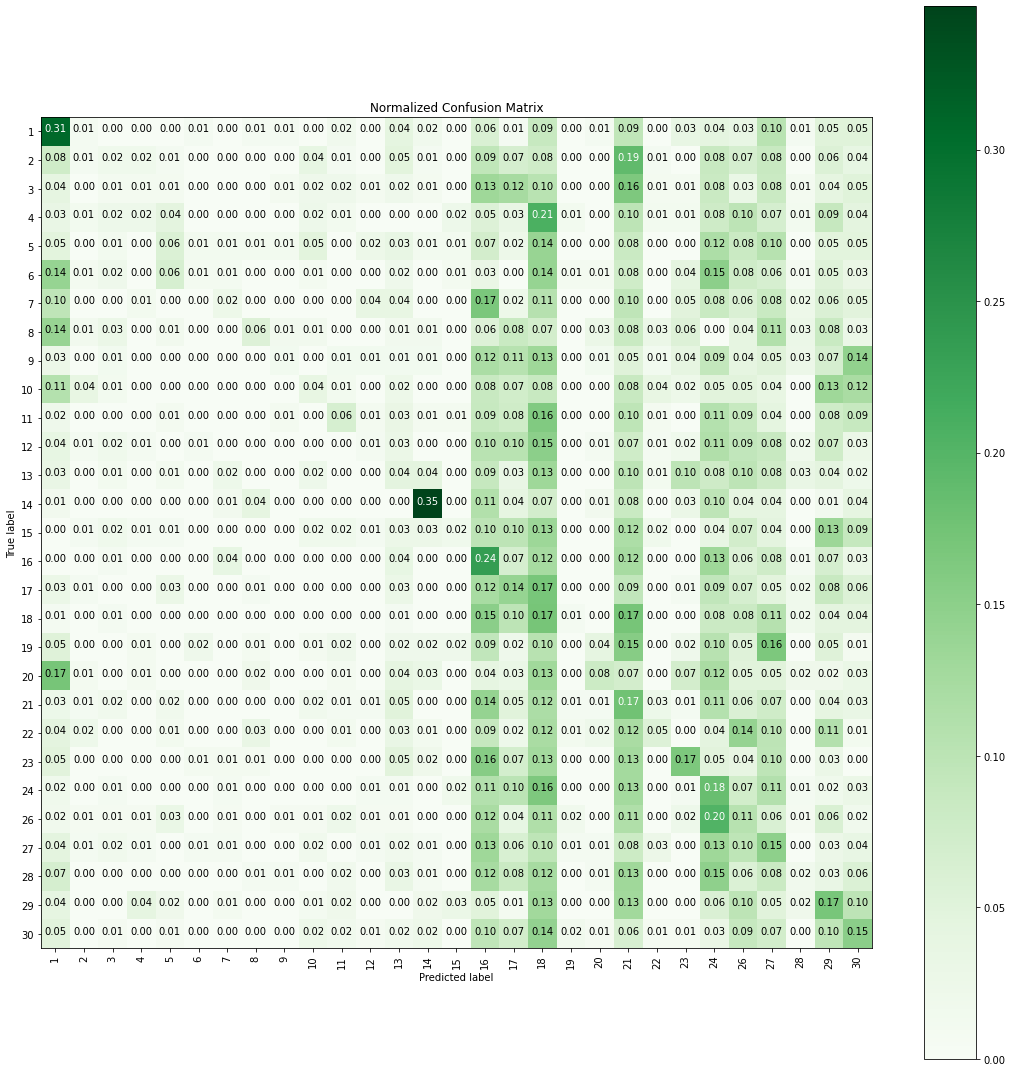


 F1 Score:0.0893838877901887


==> Best Estimator:
	RandomForestClassifier(max_depth=14, n_estimators=170)


==> Best parameters:
	Parameters of best estimator : {'max_depth': 14, 'n_estimators': 170}

==> No. of CrossValidation sets:
	Total nmber of cross validation sets: 10

==> Best Score:
	Average Cross Validate scores of Best estimator : 0.10631611221830446
--------
epsilon:  2.0
--------
training the model...
Fitting 10 folds for each of 20 candidates, totalling 200 fits
Done
==> training time:- 0:12:37.627126

Predicting test data
==> testing time:- 0:00:00.124553

==> Accuracy:- 0.10738714090287278


 ********Confusion Matrix********

 [[41  0  0  0  0  1  1  0  0  2  0  0  1  3  1 15  3 13  0  2 14  0  3  0
   6  4  0  4  3]
 [ 6  4  0  0  0  0  1  1  0  1  1  0  2  2  1  9  6 14  0  0 22  0  1 11
  10  7  0  7  0]
 [ 4  1  2  1  0  1  2  1  0  2  0  0  4  2  1  7 10  8  0  0 15  0  0  7
   7 12  0  7  4]
 [ 2  0  0  0  1  0  0  0  0  2  2  1  3  0  0  5  4 15  0  0  6  2  0 

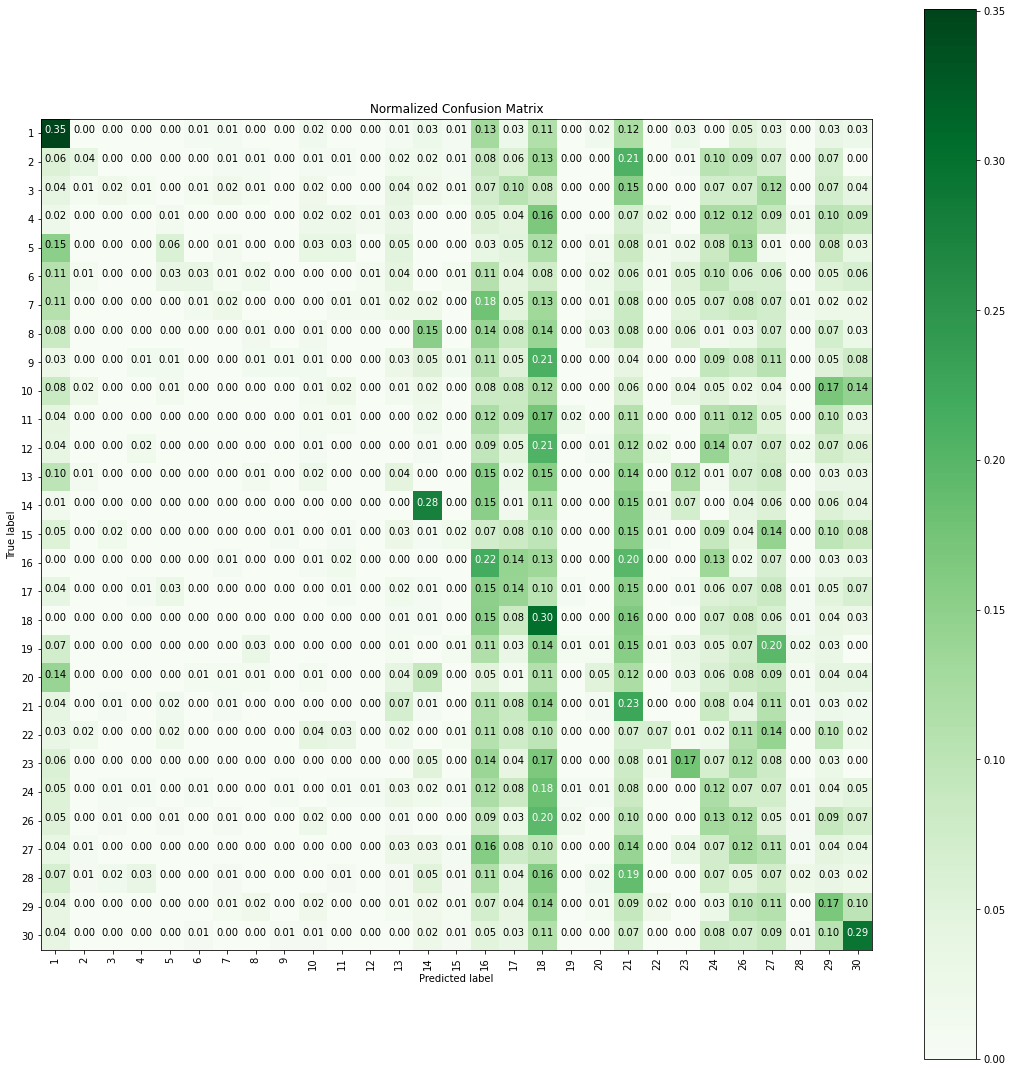


 F1 Score:0.08702563311142598


==> Best Estimator:
	RandomForestClassifier(max_depth=10, n_estimators=170)


==> Best parameters:
	Parameters of best estimator : {'max_depth': 10, 'n_estimators': 170}

==> No. of CrossValidation sets:
	Total nmber of cross validation sets: 10

==> Best Score:
	Average Cross Validate scores of Best estimator : 0.11221972393979138
--------
epsilon:  2.1
--------
training the model...
Fitting 10 folds for each of 20 candidates, totalling 200 fits
Done
==> training time:- 0:11:27.231712

Predicting test data
==> testing time:- 0:00:00.151247

==> Accuracy:- 0.11285909712722299


 ********Confusion Matrix********

 [[24  0  0  0  1  1  0  2  0  2  1  0  1  2  0 11  5 12  1  3 11  0  7  5
   6  8  1  7  6]
 [ 4  2  2  1  0  0  0  1  0  2  1  0  4  3  0  9  4  9  1  1 12  0  1  7
  16 17  1  6  2]
 [ 4  2  3  3  0  0  0  1  0  0  2  0  3  1  0  7  7 18  0  1 15  2  0 10
   4  6  0  5  4]
 [ 1  0  3  1  0  0  0  0  1  0  1  1  0  0  0  6  4 13  1  0 12  4  0

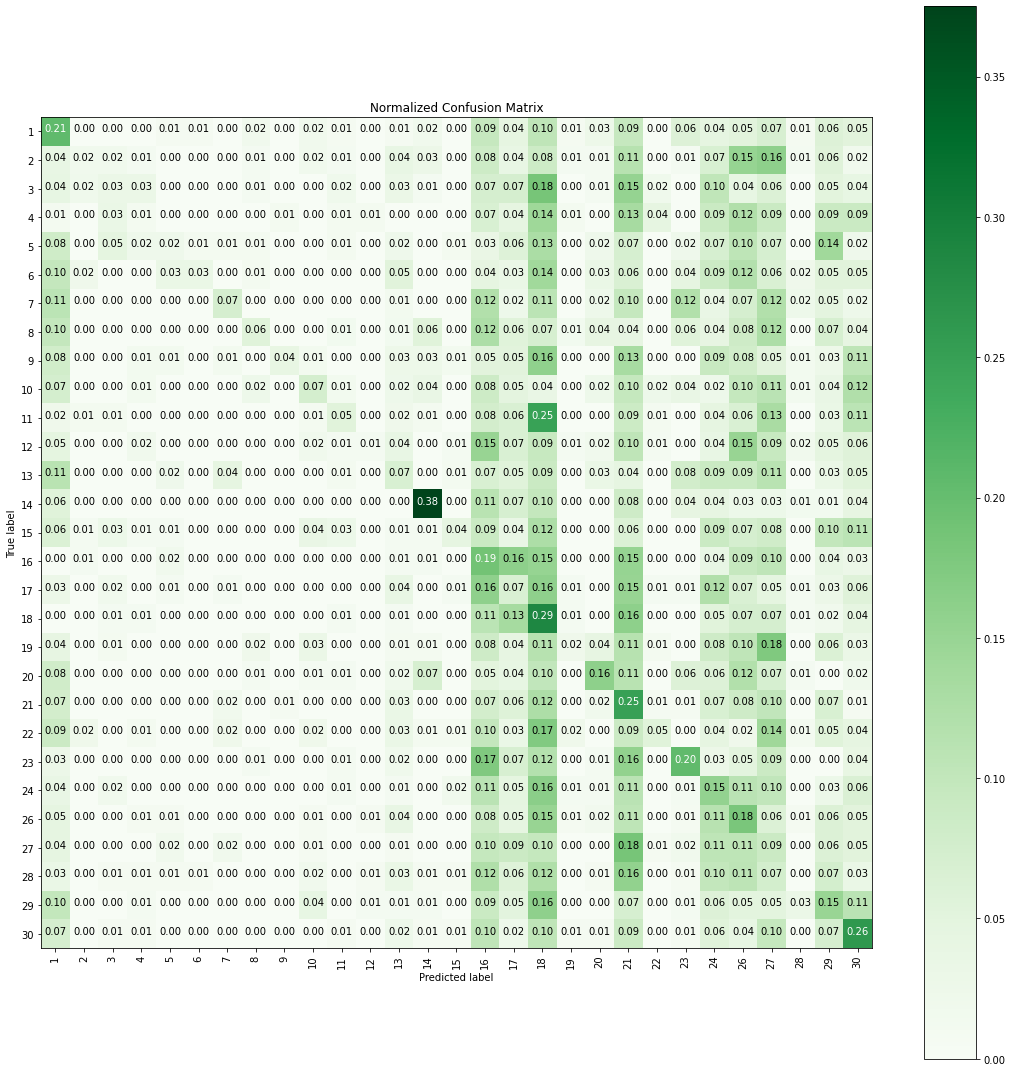


 F1 Score:0.10426633300586283


==> Best Estimator:
	RandomForestClassifier(max_depth=10, n_estimators=170)


==> Best parameters:
	Parameters of best estimator : {'max_depth': 10, 'n_estimators': 170}

==> No. of CrossValidation sets:
	Total nmber of cross validation sets: 10

==> Best Score:
	Average Cross Validate scores of Best estimator : 0.11811595437227815
--------
epsilon:  2.2
--------
training the model...
Fitting 10 folds for each of 20 candidates, totalling 200 fits
Done
==> training time:- 0:11:16.759648

Predicting test data
==> testing time:- 0:00:00.108193

==> Accuracy:- 0.12722298221614228


 ********Confusion Matrix********

 [[43  0  0  0  0  1  0  0  0  0  0  0  1  3  0  4  2 14  0  0 10  0  4  4
   7  7  1  5 11]
 [ 7  3  0  0  1  0  0  1  0  0  1  0  5  3  0  8  7 15  1  0 16  1  0  9
   8 13  1  6  0]
 [ 7  0  0  0  1  0  0  2  0  0  0  0  4  1  0  3  8 19  0  0 14  0  0 17
   8  4  1  4  5]
 [ 3  1  0  0  0  0  0  0  0  3  3  0  0  0  2  2  4 21  0  0  7  2  0

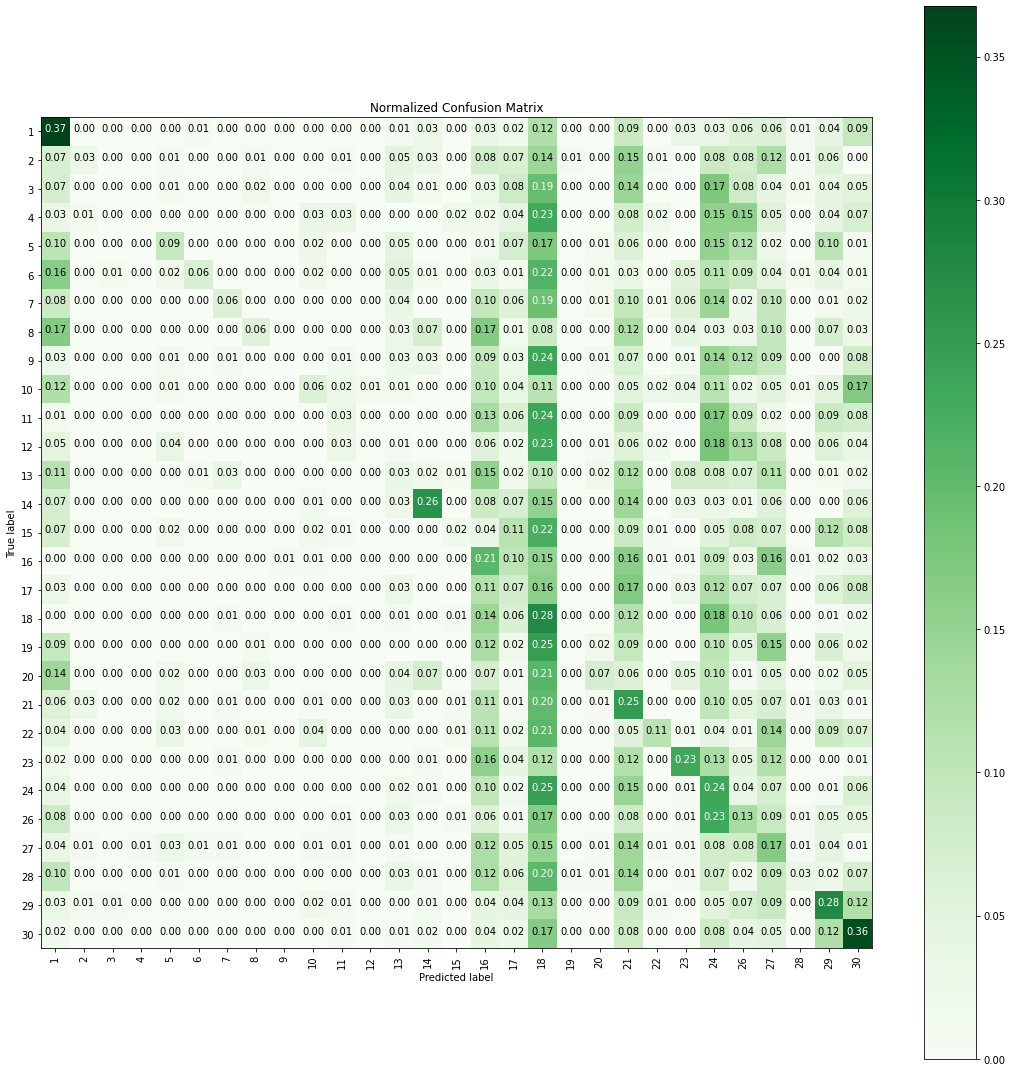


 F1 Score:0.10994465075601932


==> Best Estimator:
	RandomForestClassifier(max_depth=8, n_estimators=180)


==> Best parameters:
	Parameters of best estimator : {'max_depth': 8, 'n_estimators': 180}

==> No. of CrossValidation sets:
	Total nmber of cross validation sets: 10

==> Best Score:
	Average Cross Validate scores of Best estimator : 0.12535359213268152
--------
epsilon:  2.3
--------
training the model...
Fitting 10 folds for each of 20 candidates, totalling 200 fits
Done
==> training time:- 0:11:37.039363

Predicting test data
==> testing time:- 0:00:00.207446

==> Accuracy:- 0.1350889192886457


 ********Confusion Matrix********

 [[34  0  1  0  0  0  1  0  0  3  4  1  7  5  0  5  5 10  0  2  5  0  2  5
   5 10  1  5  6]
 [10  4  1  0  0  0  2  0  0  2  1  1  2  0  0  8  8 11  0  1 20  4  0  9
   7  8  0  4  3]
 [ 5  2  3  2  3  1  1  0  2  0  3  0  1  0  2 12  3 12  1  0 14  0  0  7
   7  8  3  3  3]
 [ 5  1  0  5  2  0  0  0  1  1  3  1  2  0  0  2  2 15  1  0  7  1  0  9

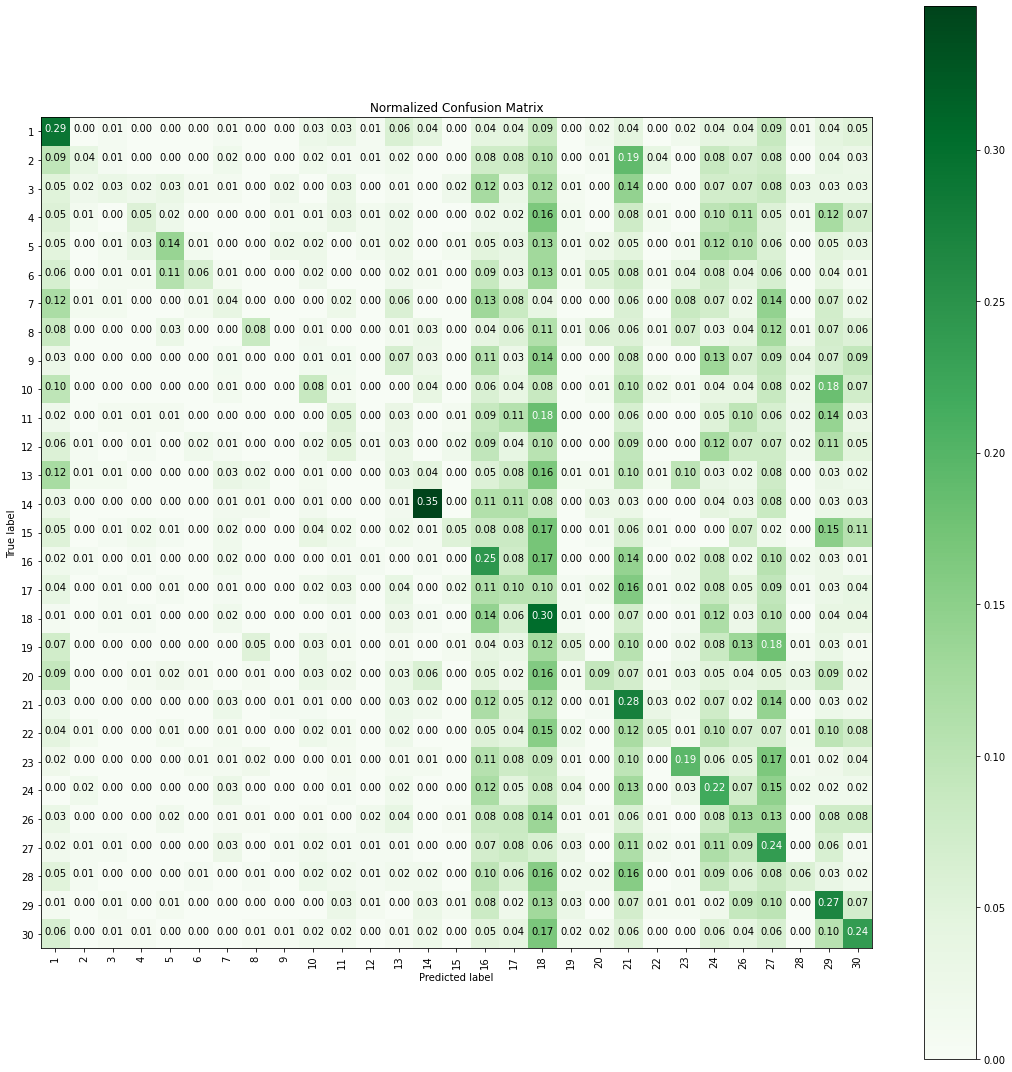


 F1 Score:0.12269169864356405


==> Best Estimator:
	RandomForestClassifier(max_depth=14, n_estimators=180)


==> Best parameters:
	Parameters of best estimator : {'max_depth': 14, 'n_estimators': 180}

==> No. of CrossValidation sets:
	Total nmber of cross validation sets: 10

==> Best Score:
	Average Cross Validate scores of Best estimator : 0.1376621754362058


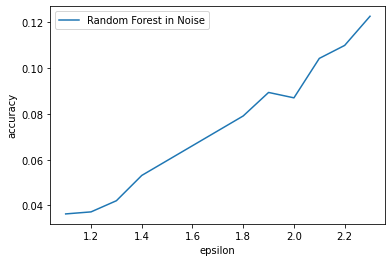

[0.03628955813844361, 0.03717706310683446, 0.04205620586207088, 0.053107270172129815, 0.07911290597280803, 0.0893838877901887, 0.08702563311142598, 0.10426633300586283, 0.10994465075601932, 0.12269169864356405]


In [33]:
import warnings
# 収束しなかった場合のwarning
from sklearn.exceptions import ConvergenceWarning
# warningを無視する
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=ConvergenceWarning)

# epsilons = [0.01, 0.05, 0.1, 0.3, 0.5, 1.0, 1.5, 2.0, 2.5, 3, 4, 5]
acc_array_random_uid = list()
f1_array_random_uid = list()


# epsilons = [1.0, 1.1, 1.2, 1.3, 1.5, 1.7, 1.8,  1.9, 2.0, 2.2, 2.5]
epsilons = [1.1, 1.2, 1.3, 1.4, 1.8, 1.9, 2.0, 2.1, 2.2, 2.3]

for epsilon in epsilons:

  print('--------')
  print('epsilon:  '+ str(epsilon))
  print('--------')

  X_train, X_test, y_train, y_test = split_train_test_data(df_concat, 'user_Id')

  # for feature in f_add_weighted_noise:
  #   print(X_train[feature])
  #   X_train[feature] = X_train[feature].apply(lambda x: x + np.random.laplace(0, 1.0/weighted_epsilon))
  #   X_test[feature] = X_test[feature].apply(lambda x: x + np.random.laplace(0, 1.0/weighted_epsilon))
  #   print(X_train[feature])

  for col in X_train:
      # default sensitivity = 1.0
    if col not in f_add_weighted_noise:
      # print("------epsilon--------")
      X_train[col] = X_train[col].apply(lambda x: x + np.random.laplace(0, 1.0/epsilon))
      X_test[col] = X_test[col].apply(lambda x: x + np.random.laplace(0, 1.0/epsilon))
    else :
      # print("------weighted_epsilon--------")
      X_train[col] = X_train[col].apply(lambda x: x + np.random.laplace(0, 1.0/weighted_epsilon))
      X_test[col] = X_test[col].apply(lambda x: x + np.random.laplace(0, 1.0/weighted_epsilon))

  
  params = {'n_estimators': np.arange(150,181,10), 'max_depth':np.arange(6,15,2)}
  rfc = RandomForestClassifier()
  rfc_grid = GridSearchCV(rfc, param_grid=params, cv=10, verbose=1, n_jobs=-1)
  rfc_grid_results, f1 = perform_model_epsilon(rfc_grid,  X_train.values, y_train.values, X_test.values, y_test.values, class_labels=labels_uid)
  f1_array_random_uid.append(f1)
  acc_array_random_uid.append(rfc_grid_results['accuracy'])
  
  # observe the attributes of the model 
  print_grid_search_attributes(rfc_grid_results['model'])
    
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(epsilons[::-1], f1_array_random_uid[::-1], label='Random Forest in Noise')
ax.set_xlabel('epsilon')
ax.set_ylabel('accuracy')
plt.legend(loc='best')
plt.show()

print(f1_array_random_uid)

## HAR

--------
epsilon:  1.1
--------
training the model...
Fitting 10 folds for each of 30 candidates, totalling 300 fits
Done
==> training time:- 0:13:09.232638

Predicting test data
==> testing time:- 0:00:00.215784

==> Accuracy:- 0.6453488372093024


 ********Confusion Matrix********

 [[435  47  52   0   5   0]
 [219 157  59   1  12   6]
 [108  26 276   0   1   1]
 [  0   1   0  53 352  77]
 [  0   0   0  22 462  32]
 [  0   0   0   4  12 504]]


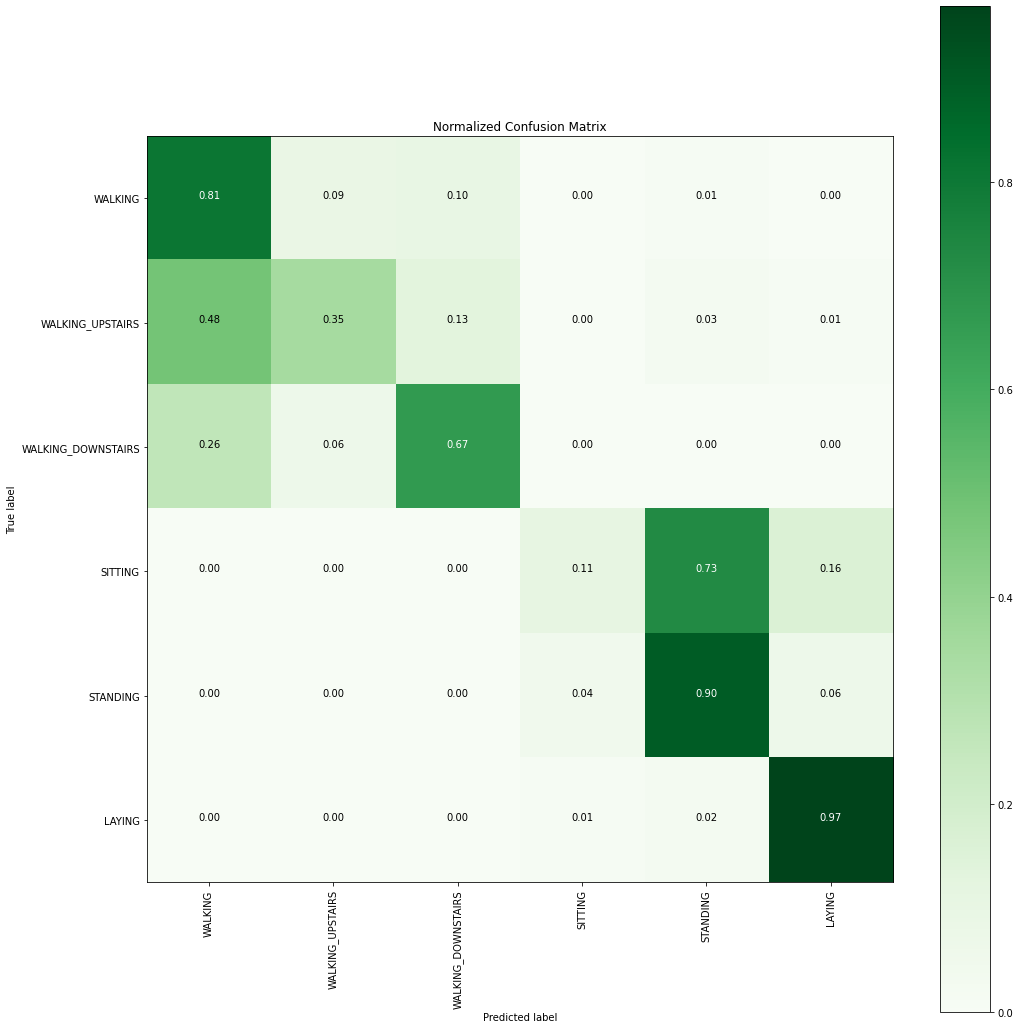


 F1 Score:0.5949789150225376


==> Best Estimator:
	RandomForestClassifier(max_depth=8, n_estimators=200)


==> Best parameters:
	Parameters of best estimator : {'max_depth': 8, 'n_estimators': 200}

==> No. of CrossValidation sets:
	Total nmber of cross validation sets: 10

==> Best Score:
	Average Cross Validate scores of Best estimator : 0.6481878935504568
--------
epsilon:  1.2
--------
training the model...
Fitting 10 folds for each of 30 candidates, totalling 300 fits
Done
==> training time:- 0:12:31.619606

Predicting test data
==> testing time:- 0:00:00.113162

==> Accuracy:- 0.6603967168262654


 ********Confusion Matrix********

 [[444  40  50   0   5   0]
 [221 173  47   2   8   3]
 [115  24 273   0   0   0]
 [  0   0   0  85 327  71]
 [  0   0   0  35 450  31]
 [  0   0   0   7   7 506]]


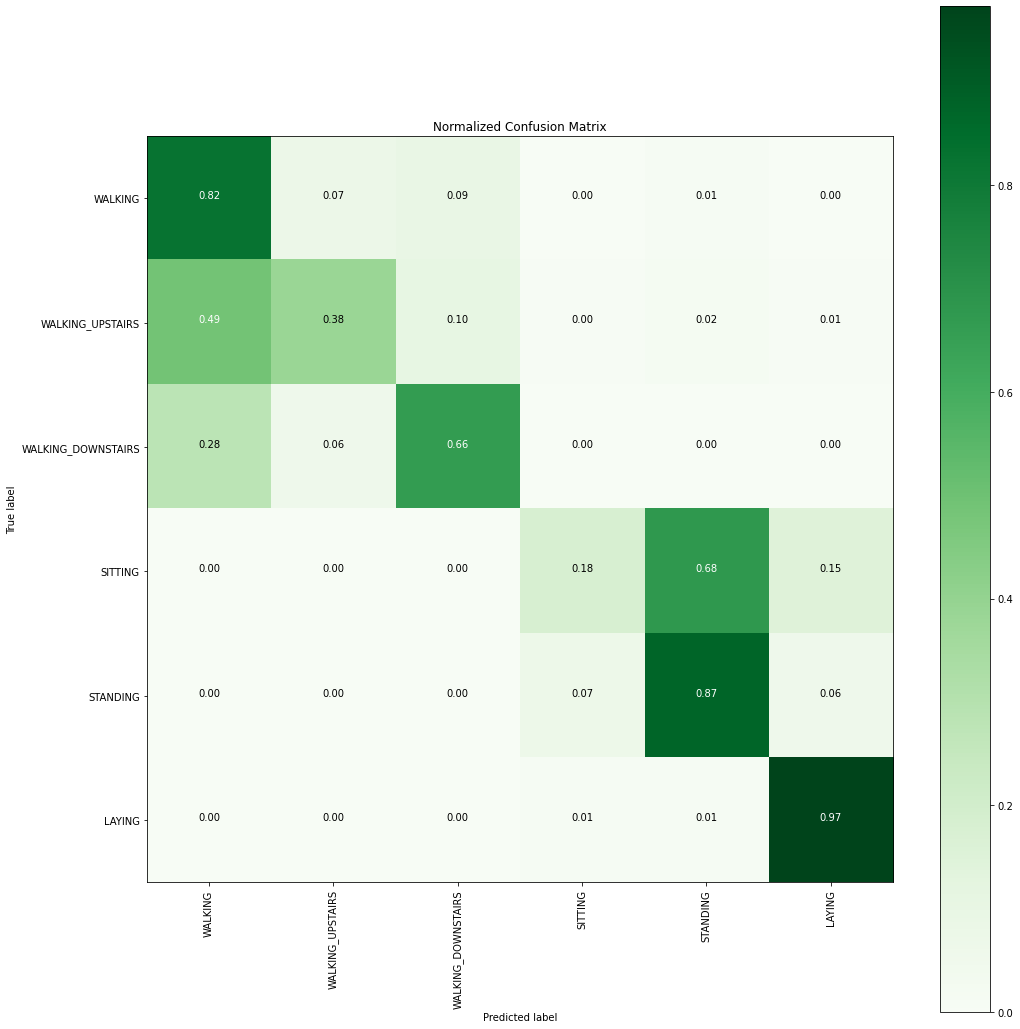


 F1 Score:0.6216974874462634


==> Best Estimator:
	RandomForestClassifier(max_depth=8, n_estimators=160)


==> Best parameters:
	Parameters of best estimator : {'max_depth': 8, 'n_estimators': 160}

==> No. of CrossValidation sets:
	Total nmber of cross validation sets: 10

==> Best Score:
	Average Cross Validate scores of Best estimator : 0.6650365373805509
--------
epsilon:  1.3
--------
training the model...
Fitting 10 folds for each of 30 candidates, totalling 300 fits
Done
==> training time:- 0:13:03.749899

Predicting test data
==> testing time:- 0:00:00.289759

==> Accuracy:- 0.6819425444596443


 ********Confusion Matrix********

 [[405  81  51   0   2   0]
 [169 245  30   1   5   4]
 [ 95  27 290   0   0   0]
 [  0   0   0 125 304  54]
 [  0   0   0  75 420  21]
 [  0   0   0   5   6 509]]


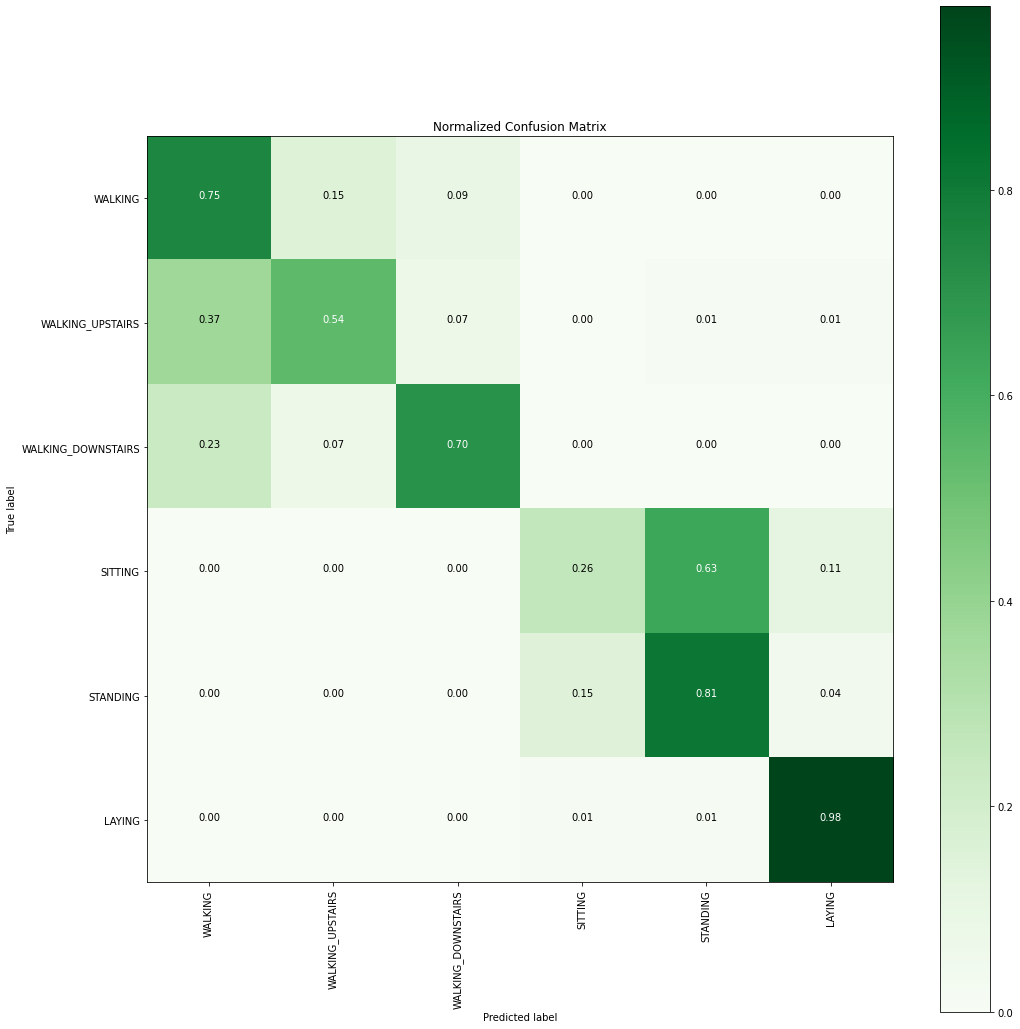


 F1 Score:0.6617443303208864


==> Best Estimator:
	RandomForestClassifier(max_depth=12, n_estimators=190)


==> Best parameters:
	Parameters of best estimator : {'max_depth': 12, 'n_estimators': 190}

==> No. of CrossValidation sets:
	Total nmber of cross validation sets: 10

==> Best Score:
	Average Cross Validate scores of Best estimator : 0.679368161661585
--------
epsilon:  1.4
--------
training the model...
Fitting 10 folds for each of 30 candidates, totalling 300 fits
Done
==> training time:- 0:14:19.065134

Predicting test data
==> testing time:- 0:00:00.246336

==> Accuracy:- 0.698358413132695


 ********Confusion Matrix********

 [[465  36  38   0   0   0]
 [181 222  41   1   7   2]
 [ 81  32 299   0   0   0]
 [  0   0   0 101 334  48]
 [  0   0   0  46 446  24]
 [  0   0   0   5   6 509]]


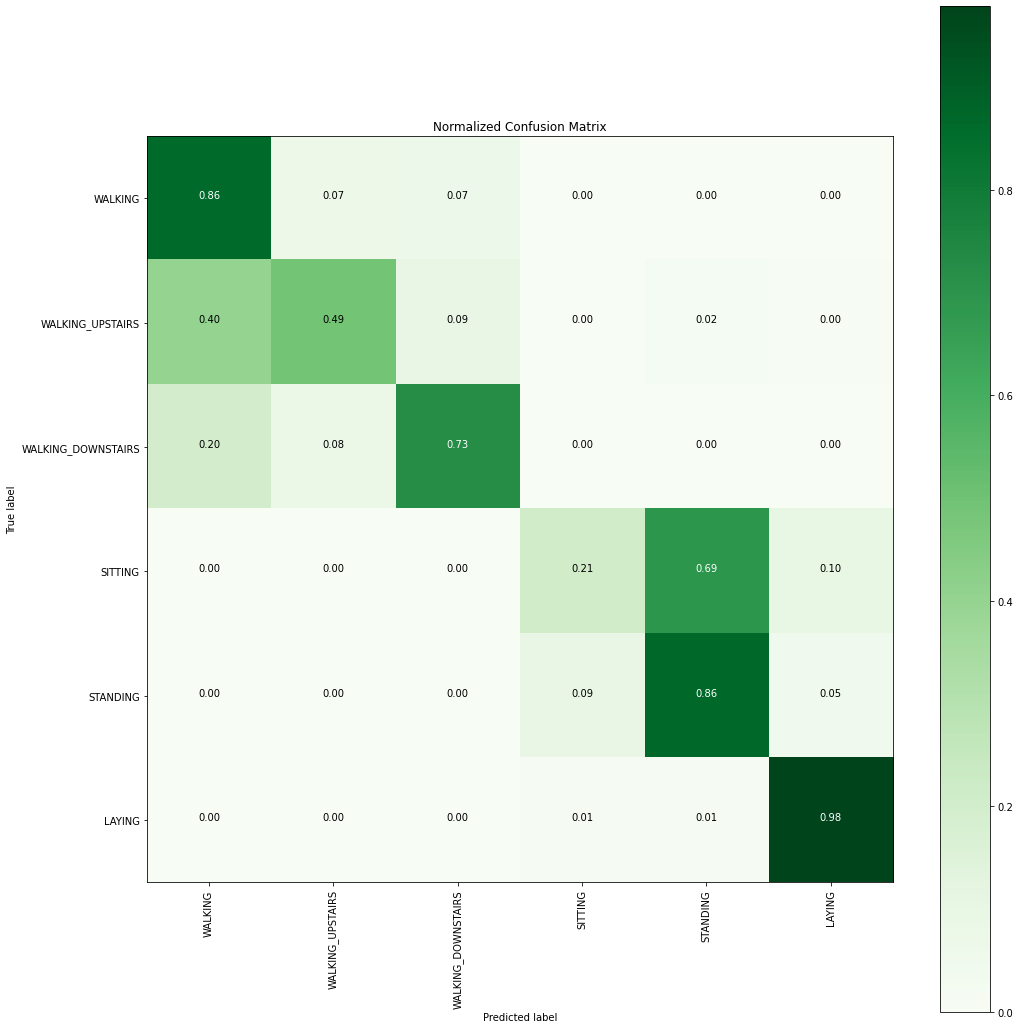


 F1 Score:0.6683861820567266


==> Best Estimator:
	RandomForestClassifier(max_depth=8, n_estimators=170)


==> Best parameters:
	Parameters of best estimator : {'max_depth': 8, 'n_estimators': 170}

==> No. of CrossValidation sets:
	Total nmber of cross validation sets: 10

==> Best Score:
	Average Cross Validate scores of Best estimator : 0.7004184623071639
--------
epsilon:  1.8
--------
training the model...
Fitting 10 folds for each of 30 candidates, totalling 300 fits
Done
==> training time:- 0:28:48.936003

Predicting test data
==> testing time:- 0:00:00.141679

==> Accuracy:- 0.7421340629274966


 ********Confusion Matrix********

 [[439  59  41   0   0   0]
 [136 287  29   1   1   0]
 [ 67  36 309   0   0   0]
 [  0   0   0 155 295  33]
 [  0   0   0  51 460   5]
 [  0   0   0   0   0 520]]


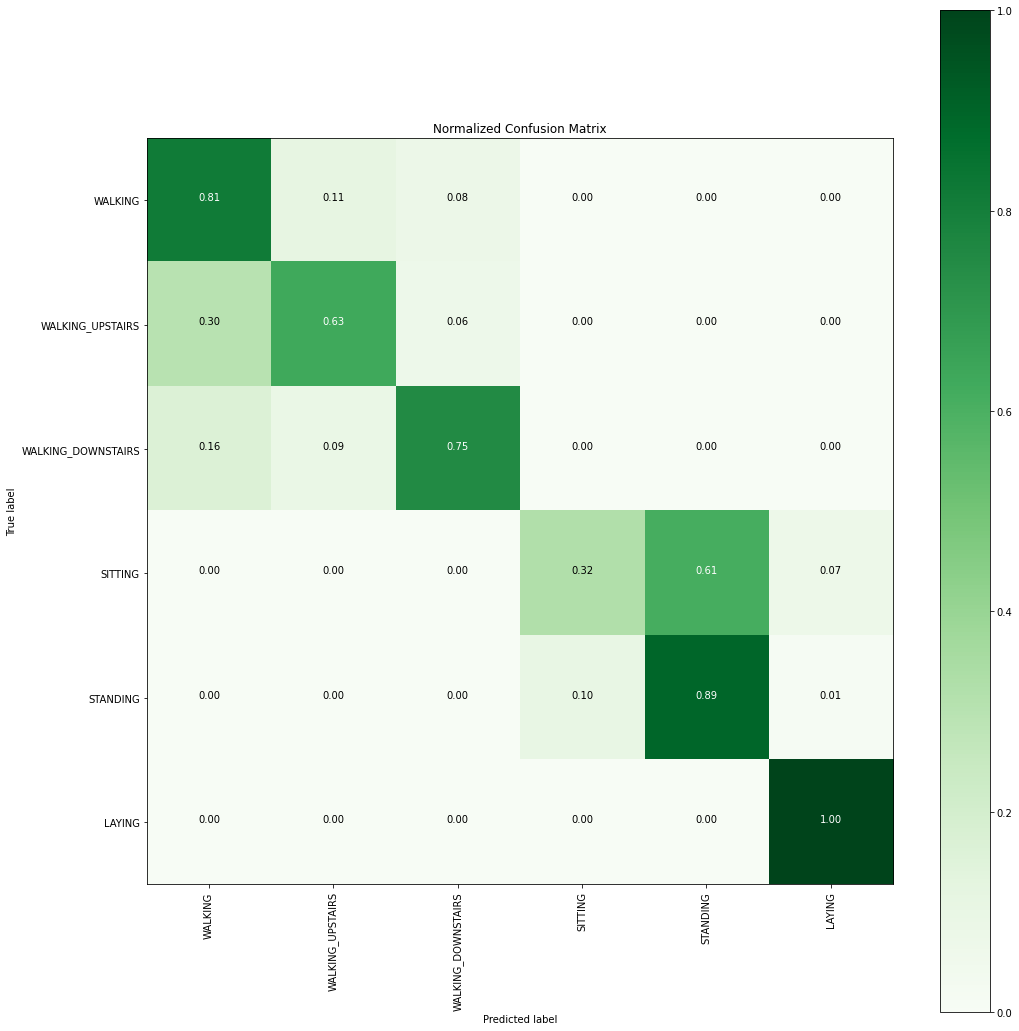


 F1 Score:0.7247709135202346


==> Best Estimator:
	RandomForestClassifier(max_depth=12, n_estimators=190)


==> Best parameters:
	Parameters of best estimator : {'max_depth': 12, 'n_estimators': 190}

==> No. of CrossValidation sets:
	Total nmber of cross validation sets: 10

==> Best Score:
	Average Cross Validate scores of Best estimator : 0.755185071626893
--------
epsilon:  1.9
--------
training the model...
Fitting 10 folds for each of 30 candidates, totalling 300 fits
Done
==> training time:- 2:07:17.434486

Predicting test data
==> testing time:- 0:00:00.123781

==> Accuracy:- 0.7629958960328317


 ********Confusion Matrix********

 [[456  51  31   0   1   0]
 [111 301  39   0   3   0]
 [ 68  29 315   0   0   0]
 [  0   0   0 168 277  38]
 [  0   0   0  40 473   3]
 [  0   0   0   2   0 518]]


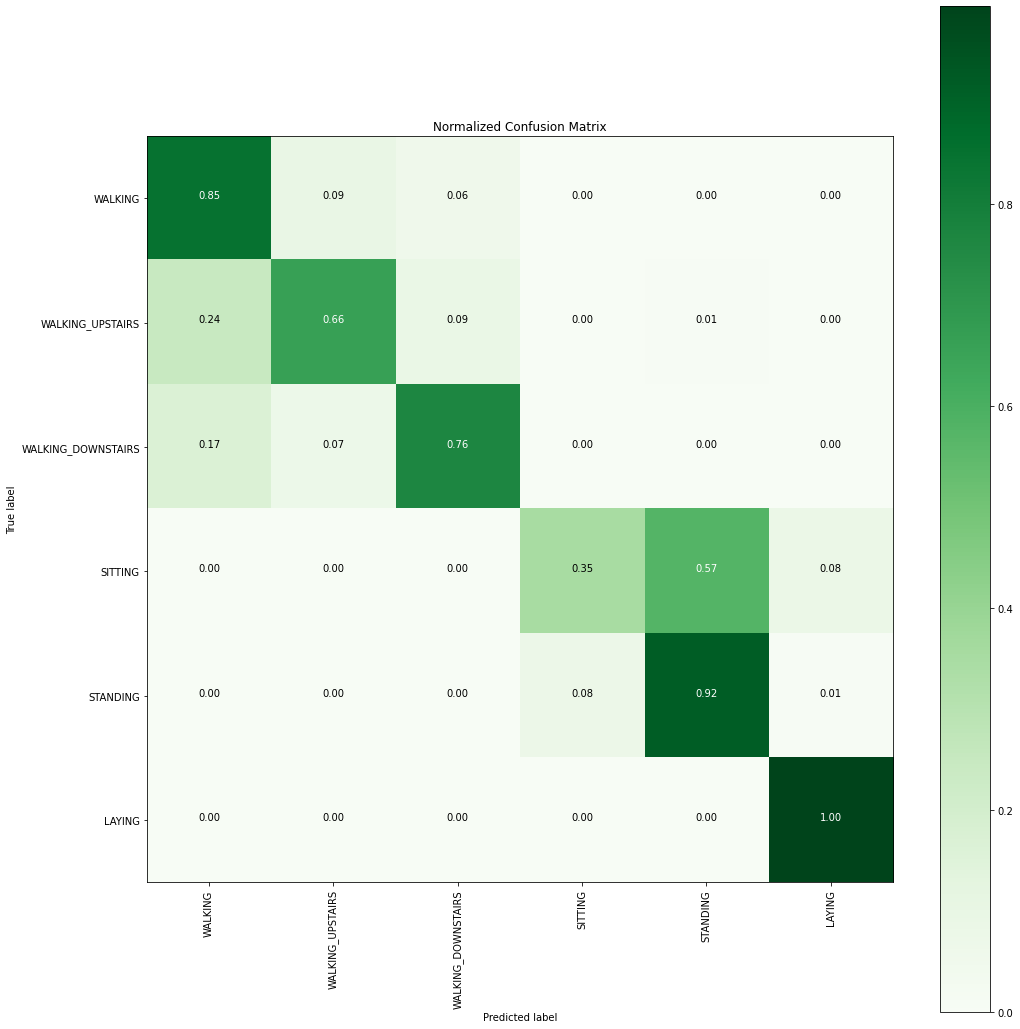


 F1 Score:0.7463553884372854


==> Best Estimator:
	RandomForestClassifier(max_depth=10, n_estimators=200)


==> Best parameters:
	Parameters of best estimator : {'max_depth': 10, 'n_estimators': 200}

==> No. of CrossValidation sets:
	Total nmber of cross validation sets: 10

==> Best Score:
	Average Cross Validate scores of Best estimator : 0.7624241288659501
--------
epsilon:  2.0
--------
training the model...
Fitting 10 folds for each of 30 candidates, totalling 300 fits
Done
==> training time:- 2:15:48.275822

Predicting test data
==> testing time:- 0:00:00.112649

==> Accuracy:- 0.7616279069767442


 ********Confusion Matrix********

 [[451  51  37   0   0   0]
 [111 303  40   0   0   0]
 [ 75  30 307   0   0   0]
 [  0   0   0 175 271  37]
 [  0   0   0  44 471   1]
 [  0   0   0   0   0 520]]


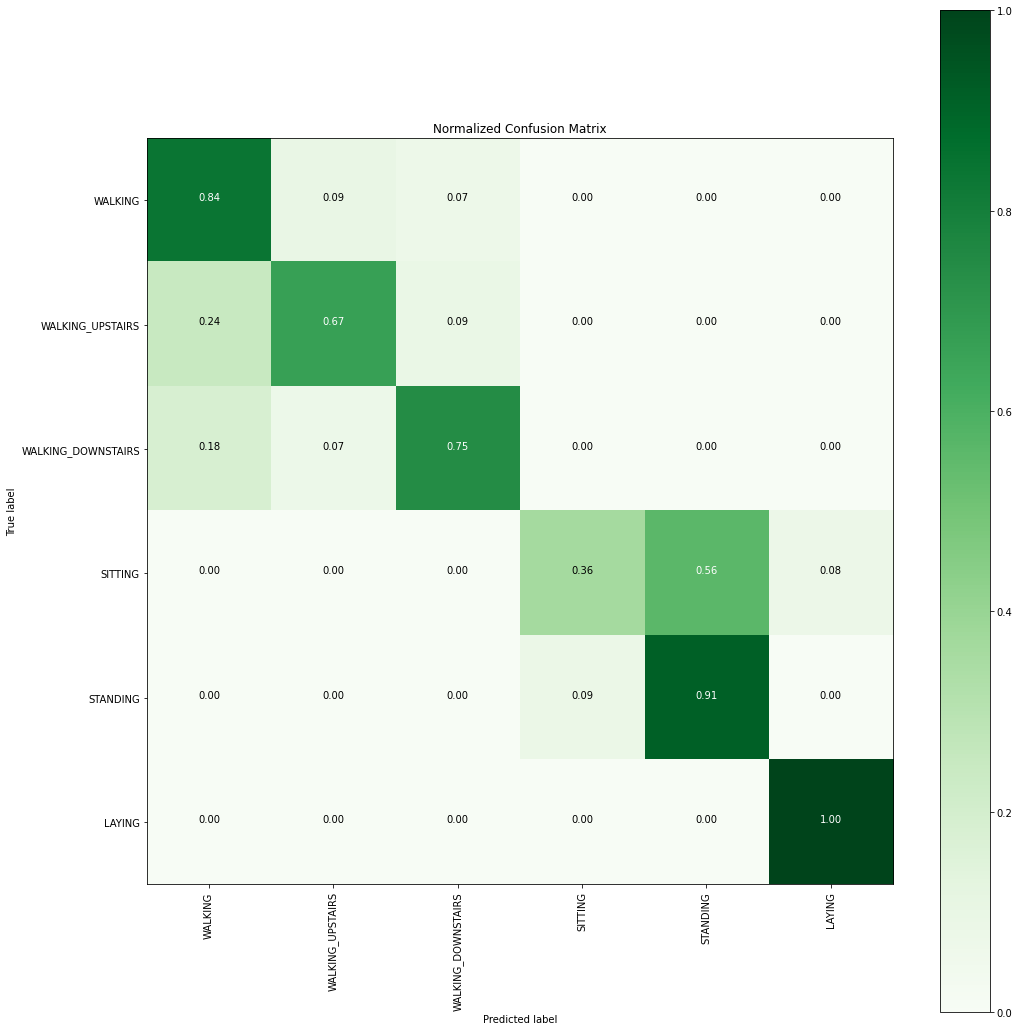


 F1 Score:0.7456077684250153


==> Best Estimator:
	RandomForestClassifier(max_depth=10, n_estimators=200)


==> Best parameters:
	Parameters of best estimator : {'max_depth': 10, 'n_estimators': 200}

==> No. of CrossValidation sets:
	Total nmber of cross validation sets: 10

==> Best Score:
	Average Cross Validate scores of Best estimator : 0.7723721191680719
--------
epsilon:  2.1
--------
training the model...
Fitting 10 folds for each of 30 candidates, totalling 300 fits
Done
==> training time:- 1:27:48.721362

Predicting test data
==> testing time:- 0:00:00.196160

==> Accuracy:- 0.789671682626539


 ********Confusion Matrix********

 [[453  52  34   0   0   0]
 [101 327  25   0   1   0]
 [ 56  38 318   0   0   0]
 [  0   0   0 218 242  23]
 [  0   0   0  40 474   2]
 [  0   0   0   1   0 519]]


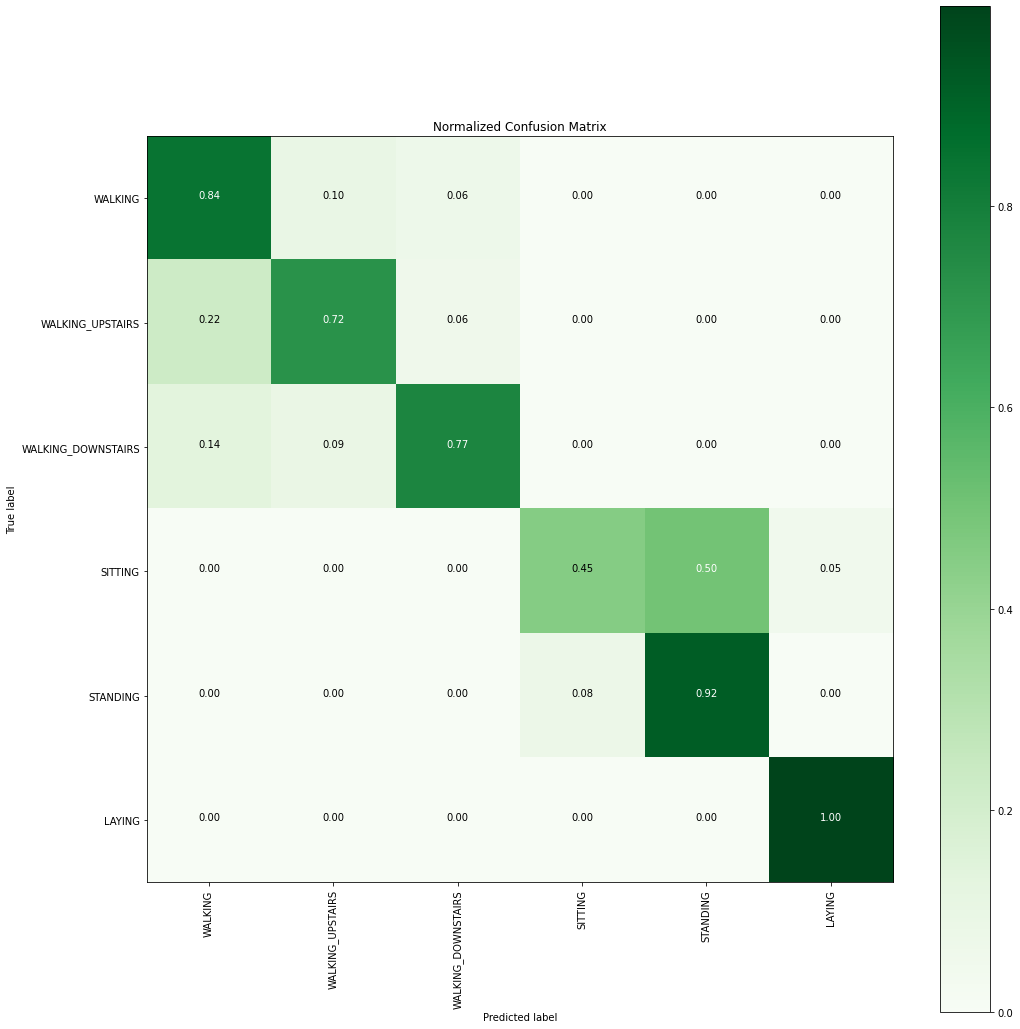


 F1 Score:0.7795796523977961


==> Best Estimator:
	RandomForestClassifier(max_depth=10, n_estimators=170)


==> Best parameters:
	Parameters of best estimator : {'max_depth': 10, 'n_estimators': 170}

==> No. of CrossValidation sets:
	Total nmber of cross validation sets: 10

==> Best Score:
	Average Cross Validate scores of Best estimator : 0.7831561823973291
--------
epsilon:  2.2
--------
training the model...
Fitting 10 folds for each of 30 candidates, totalling 300 fits
Done
==> training time:- 0:11:21.675601

Predicting test data
==> testing time:- 0:00:00.228464

==> Accuracy:- 0.780437756497948


 ********Confusion Matrix********

 [[456  55  28   0   0   0]
 [ 90 326  36   0   2   0]
 [ 61  49 302   0   0   0]
 [  0   0   0 215 240  28]
 [  0   0   0  52 463   1]
 [  0   0   0   0   0 520]]


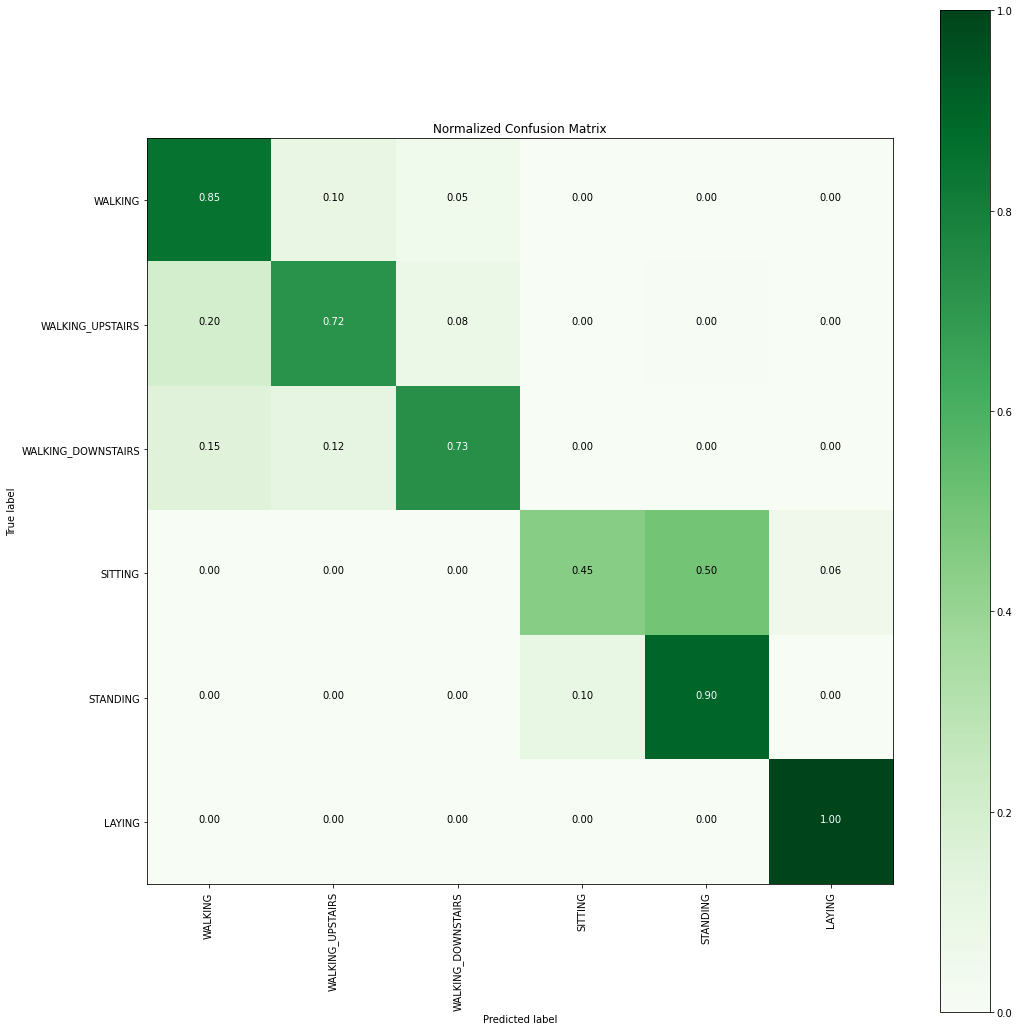


 F1 Score:0.7690529380630563


==> Best Estimator:
	RandomForestClassifier(max_depth=12, n_estimators=180)


==> Best parameters:
	Parameters of best estimator : {'max_depth': 12, 'n_estimators': 180}

==> No. of CrossValidation sets:
	Total nmber of cross validation sets: 10

==> Best Score:
	Average Cross Validate scores of Best estimator : 0.7909045485773984
--------
epsilon:  2.3
--------
training the model...
Fitting 10 folds for each of 30 candidates, totalling 300 fits
Done
==> training time:- 0:12:17.390602

Predicting test data
==> testing time:- 0:00:00.126360

==> Accuracy:- 0.7937756497948016


 ********Confusion Matrix********

 [[445  65  29   0   0   0]
 [ 84 336  33   0   1   0]
 [ 56  45 311   0   0   0]
 [  0   0   0 242 220  21]
 [  0   0   0  45 470   1]
 [  0   0   0   2   1 517]]


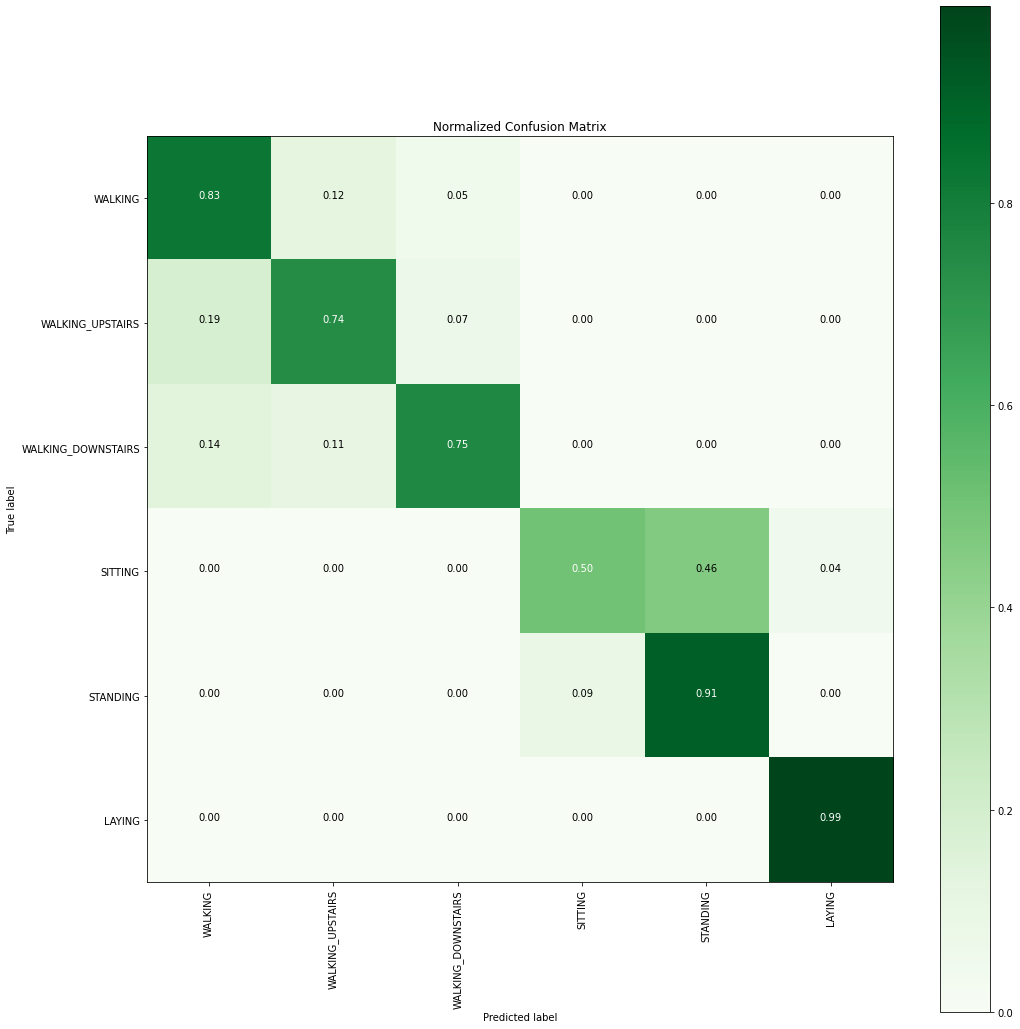


 F1 Score:0.7853866375246462


==> Best Estimator:
	RandomForestClassifier(max_depth=14, n_estimators=180)


==> Best parameters:
	Parameters of best estimator : {'max_depth': 14, 'n_estimators': 180}

==> No. of CrossValidation sets:
	Total nmber of cross validation sets: 10

==> Best Score:
	Average Cross Validate scores of Best estimator : 0.7993314255540225


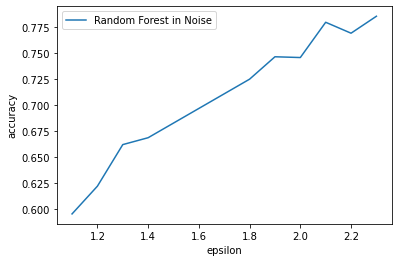

[0.5949789150225376, 0.6216974874462634, 0.6617443303208864, 0.6683861820567266, 0.7247709135202346, 0.7463553884372854, 0.7456077684250153, 0.7795796523977961, 0.7690529380630563, 0.7853866375246462]


In [34]:
import warnings
# 収束しなかった場合のwarning
from sklearn.exceptions import ConvergenceWarning
# warningを無視する
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=ConvergenceWarning)

# epsilons = [0.01, 0.05, 0.1, 0.3, 0.5, 1.0, 1.5, 2.0, 2.5, 3, 4, 5]
acc_array_random_har = list()
f1_array_random_har = list()


# epsilons = [1.0, 1.1, 1.2, 1.3, 1.5, 1.7, 1.8,  1.9, 2.0, 2.2, 2.5]
epsilons = [1.1, 1.2, 1.3, 1.4, 1.8, 1.9, 2.0, 2.1, 2.2, 2.3]


for epsilon in epsilons:

  print('--------')
  print('epsilon:  '+ str(epsilon))
  print('--------')

  X_train, X_test, y_train, y_test = split_train_test_data(df_concat, 'activity_Id')

  # for feature in f_add_weighted_noise:
  #   X_train[feature] = X_train[feature].apply(lambda x: x + np.random.laplace(0, 1.0/weighted_epsilon))
  #   X_test[feature] = X_test[feature].apply(lambda x: x + np.random.laplace(0, 1.0/weighted_epsilon))

  for col in X_train:
      # default sensitivity = 1.0
    if col not in f_add_weighted_noise:
      # print("------epsilon--------")
      X_train[col] = X_train[col].apply(lambda x: x + np.random.laplace(0, 1.0/epsilon))
      X_test[col] = X_test[col].apply(lambda x: x + np.random.laplace(0, 1.0/epsilon))
    else :
      # print("------weighted_epsilon--------")
      X_train[col] = X_train[col].apply(lambda x: x + np.random.laplace(0, 1.0/weighted_epsilon))
      X_test[col] = X_test[col].apply(lambda x: x + np.random.laplace(0, 1.0/weighted_epsilon))

    
  params = {'n_estimators': np.arange(150,201,10), 'max_depth':np.arange(6,15,2)}
  rfc = RandomForestClassifier()
  rfc_grid = GridSearchCV(rfc, param_grid=params, cv=10, verbose=1, n_jobs=-1)
  rfc_grid_results, f1 = perform_model_epsilon(rfc_grid, X_train.values, y_train.values, X_test.values, y_test.values, class_labels=labels_act)
  f1_array_random_har.append(f1)
  acc_array_random_har.append(rfc_grid_results['accuracy'])
  
  # observe the attributes of the model 
  print_grid_search_attributes(rfc_grid_results['model'])
    
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(epsilons[::-1], f1_array_random_har[::-1], label='Random Forest in Noise')
ax.set_xlabel('epsilon')
ax.set_ylabel('accuracy')
plt.legend(loc='best')
plt.show()

print(f1_array_random_har)

In [35]:
# epsilons = [1.1, 1.2, 1.3, 1.4, 1.8, 1.9, 2.0, 2.1, 2.2, 2.3]
print(f1_array_random_har)
print(f1_array_random_uid)
print(acc_array_random_har)
print(acc_array_random_uid)

[0.5949789150225376, 0.6216974874462634, 0.6617443303208864, 0.6683861820567266, 0.7247709135202346, 0.7463553884372854, 0.7456077684250153, 0.7795796523977961, 0.7690529380630563, 0.7853866375246462]
[0.03628955813844361, 0.03717706310683446, 0.04205620586207088, 0.053107270172129815, 0.07911290597280803, 0.0893838877901887, 0.08702563311142598, 0.10426633300586283, 0.10994465075601932, 0.12269169864356405]
[0.6453488372093024, 0.6603967168262654, 0.6819425444596443, 0.698358413132695, 0.7421340629274966, 0.7629958960328317, 0.7616279069767442, 0.789671682626539, 0.780437756497948, 0.7937756497948016]
[0.051641586867305064, 0.05950752393980848, 0.057797537619699045, 0.06224350205198358, 0.10191518467852258, 0.10020519835841313, 0.10738714090287278, 0.11285909712722299, 0.12722298221614228, 0.1350889192886457]


In [36]:
print(weighted_epsilon)
print(n)
print(epsilons)

0.001
119
[1.1, 1.2, 1.3, 1.4, 1.8, 1.9, 2.0, 2.1, 2.2, 2.3]


In [37]:
def beep():
  from google.colab import output
  output.eval_js('new Audio(\
"https://upload.wikimedia.org/wikipedia/commons/0/05/Beep-09.ogg")\
.play()') 

In [38]:
beep()

ModuleNotFoundError: No module named 'google.colab'